In [1]:
# --- Setup: make local package importable from /src and load core functions ---
# Notebook runs from /notebooks, so we add ../src to sys.path.
# Keep imports minimal here; anything reusable should live in src/picml/.
import sys
from pathlib import Path

# we are in notebooks/, so repo root is one level up
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT / "src"))

from picml.dataio import load_case_A
print("✅ Imported load_case_A")


✅ Imported load_case_A


In [2]:
import sys
print(sys.executable)
print(sys.version)

/u/60/pereire1/unix/miniconda3/envs/picml/bin/python
3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]


In [3]:
import tensorflow as tf
print(tf.__version__)


2026-01-09 12:41:36.764598: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-09 12:41:36.764863: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-09 12:41:36.799638: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-09 12:41:37.879090: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

2.20.0


In [4]:
from picml.utils import fidelity_imag
from picml.models import create_model_A_1
from sklearn.model_selection import train_test_split
from picml.training import train_case_A_model1
from picml.theory import load_frequencies, generate_case_A_model2_spectra
from picml.models import create_model_A_2
from picml.training import train_case_A_model2
from picml.utils import sort_by_peak_frequency

In [5]:
import numpy as np
import math as m
import scipy
from scipy import linalg
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
# --- Load Case A dataset (measured spectra X and targets y) ---
# X: measured spectra per ring (rows = chains*rings, cols = frequency bins)
# y: onsite loss per ring (same row order as X)

X, y = load_case_A(use_compensated=False)
y = y.reshape(-1, 1)

print("X:", X.shape)
print("y:", y.shape)


X: (1600, 40)
y: (1600, 1)


In [7]:
# --- Train/test split by chain (not by individual rings) ---
# Prevents leakage: all 8 rings of a chain go either to train or test.
# groups_* keeps chain IDs aligned with each row (useful for debugging later).

import numpy as np

num_sites = 8
num_chains = len(y) // num_sites

# Create group IDs
group_ids = np.arange(num_chains)

# Split by chains
train_chains, test_chains = train_test_split(group_ids, test_size=0.2, random_state=42)

# Now build train/test sets site-by-site, but only from the chosen chains
train_mask = np.isin(np.repeat(group_ids, num_sites), train_chains)
test_mask  = np.isin(np.repeat(group_ids, num_sites), test_chains)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]
groups_train    = np.repeat(train_chains, num_sites)
groups_test     = np.repeat(test_chains, num_sites)




#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(1280, 40)
(320, 40)


In [8]:
# --- Scale inputs (X) only ---
# We intentionally keep y in physical units (no y scaling).
# IMPORTANT: fit scaler on train only; apply to test with transform().

scalerx = StandardScaler()
X_train_scaled = scalerx.fit_transform(X_train)
X_test_scaled = scalerx.transform(X_test)

y_train_scaled = y_train
y_test_scaled = y_test

"Stage 1 : prediction of Hamiltonian parameters"

In [9]:
# --- Stage 1: predict onsite loss from measured spectra ---
# Model 1 learns y from X_train_scaled.
# Keep a short smoke-test first; increase epochs only after plumbing works.


model = create_model_A_1(input_shape=X_train_scaled.shape[1:])
model.summary()


2026-01-09 12:41:39.819196: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x_input (InputLayer)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,681 (10.47 KB)

 Trainable params: 2,681 (10.47 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# --- Stage 1 evaluation ---
# Print a few predictions vs truth to catch obvious failures (constant output, NaNs, etc.).

model.compile(optimizer="adam", loss="mse")

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=2,          # just a smoke test
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

loss = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test loss:", float(loss))


Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9534 - val_loss: 2.0784
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3273 - val_loss: 0.9425
Test loss: 0.8231322169303894


In [11]:

model, history.history, test_loss = train_case_A_model1(X_train_scaled,
    y_train,
    X_test_scaled,
    y_test)


# Evaluate
loss = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test loss:", float(loss))

# Predictions (optional)
y_pred_train = model.predict(X_train_scaled)
y_pred_test  = model.predict(X_test_scaled)

print("y_pred_train:", y_pred_train.shape, "y_train:", y_train.shape)
print("y_pred_test :", y_pred_test.shape,  "y_test :", y_test.shape)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7831 - val_loss: 1.7635
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1383 - val_loss: 0.8886
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5468 - val_loss: 0.4255
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2855 - val_loss: 0.2494
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2002 - val_loss: 0.1965
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1626 - val_loss: 0.1680
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1365 - val_loss: 0.1374
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1163 - val_loss: 0.1151
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1117 - val_loss: 0.1064
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0985 - val_loss: 0.1091
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0967 - val_loss: 0.0994
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0

In [12]:
# --- Stage 1 diagnostic metric (fidelity/correlation-like) ---
# Uses picml.utils.fidelity_imag; do not redefine it here.
# Watch out: if predictions collapse to constant, variance ~0 and fidelity can be NaN.

# Flatten to 1D
y_pred_train_1d = np.squeeze(y_pred_train)
y_pred_test_1d  = np.squeeze(y_pred_test)
y_train_1d      = np.squeeze(y_train)
y_test_1d       = np.squeeze(y_test)

print("max(y_pred_test):", float(np.max(y_pred_test_1d)))

# Fidelity (correlation-like)
F_imag_train = fidelity_imag(y_pred_train_1d, y_train_1d)
F_imag_test  = fidelity_imag(y_pred_test_1d,  y_test_1d)

print(f"Fidelity (Imag): Train ({F_imag_train:.4f}), Test ({F_imag_test:.4f})")

# Diagnostics: check for near-constant outputs
print("Var(pred train):", float(np.var(y_pred_train_1d)))
print("Var(pred test) :", float(np.var(y_pred_test_1d)))


max(y_pred_test): 4.019267559051514
Fidelity (Imag): Train (0.9852), Test (0.9851)
Var(pred train): 0.9038890600204468
Var(pred test) : 0.8640470504760742


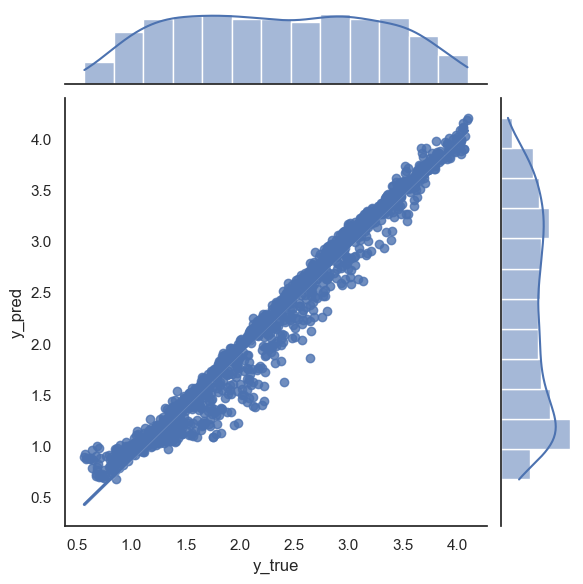

In [13]:
# plot predicted vs true Hamiltonian parameters
import pandas as pd
import seaborn as sns
y_true = np.squeeze(y_train_scaled)
y_pred = y_pred_train_1d

#Convert validation predictions to pandas dataframe
df_pred_train = pd.DataFrame({'y_true':y_true, 'y_pred': y_pred})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true', y='y_pred', data=df_pred_train, kind="reg")

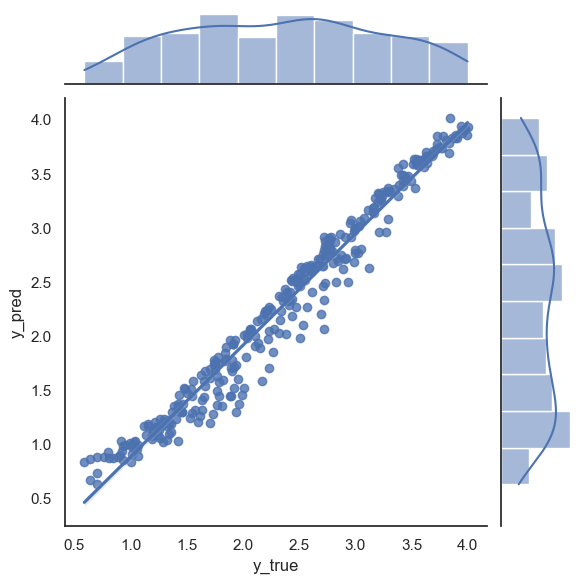

In [14]:

import pandas as pd
import seaborn as sns
y_true = np.squeeze(y_test_scaled)
y_pred = y_pred_test_1d

#Convert validation predictions to pandas dataframe
df_pred_test = pd.DataFrame({'y_true':y_true, 'y_pred': y_pred})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true', y='y_pred', data=df_pred_test, kind="reg")

"Stage 2 : prediction of experimental data from the theory data of predicted parameters"

In [15]:
# --- Reshape Stage 1 outputs into (n_chains, n_rings) for theory generation ---
# Model 2 uses grouped parameters to generate theoretical spectra per ring.


# Initialize containers
predicted_losses_grouped_train = []
true_losses_grouped_train = []
predicted_losses_grouped_test = []
true_losses_grouped_test = []

# ---- Train regrouping ----
unique_chains_train = np.unique(groups_train)

for chain_id in unique_chains_train:
    idx = np.where(groups_train == chain_id)[0]
    idx_sorted = np.sort(idx)

    predicted_chain_losses = y_pred_train[idx_sorted]
    true_chain_losses = y_train[idx_sorted]

    predicted_losses_grouped_train.append(predicted_chain_losses)
    true_losses_grouped_train.append(true_chain_losses)

# ---- Test regrouping ----
unique_chains_test = np.unique(groups_test)

for chain_id in unique_chains_test:
    idx = np.where(groups_test == chain_id)[0]
    idx_sorted = np.sort(idx)

    predicted_chain_losses = y_pred_test[idx_sorted]
    true_chain_losses = y_test[idx_sorted]

    predicted_losses_grouped_test.append(predicted_chain_losses)
    true_losses_grouped_test.append(true_chain_losses)

# Convert to arrays
predicted_losses_grouped_train = np.array(predicted_losses_grouped_train)  # (num_chains_train, 8)
true_losses_grouped_train = np.array(true_losses_grouped_train)

predicted_losses_grouped_test = np.array(predicted_losses_grouped_test)    # (num_chains_test, 8)
true_losses_grouped_test = np.array(true_losses_grouped_test)

# Shapes check
print("Train predicted shape:", predicted_losses_grouped_train.shape)
print("Train true shape:", true_losses_grouped_train.shape)
print("Test predicted shape:", predicted_losses_grouped_test.shape)
print("Test true shape:", true_losses_grouped_test.shape)


Train predicted shape: (160, 8, 1)
Train true shape: (160, 8, 1)
Test predicted shape: (40, 8, 1)
Test true shape: (40, 8, 1)


In [16]:
# --- Load frequency grid (for theory spectra generation) ---
# Use explicit path to /data to avoid cwd issues when running from notebooks/.
# --- Stage 2 data: generate theoretical spectra from inferred parameters ---
# X1_*_pred: theory spectra using predicted parameters (pipeline-realistic)
# X1_*_true: theory spectra using true parameters (diagnostic only; never for training selection)

from pathlib import Path
import numpy as np

# (or from picml.theory import ... if you renamed)

DATA_DIR = Path.cwd().parent / "data"/"case_A"
freqs = load_frequencies(DATA_DIR / "frequencies.txt", scale_2pi=True)

pred_train = np.squeeze(predicted_losses_grouped_train)
true_train = np.squeeze(true_losses_grouped_train)
pred_test  = np.squeeze(predicted_losses_grouped_test)
true_test  = np.squeeze(true_losses_grouped_test)


X1_train_pred, X1_train_true, X1_test_pred, X1_test_true = (
    generate_case_A_model2_spectra(
        predicted_losses_train=pred_train,
        true_losses_train=true_train,
        predicted_losses_test=pred_test,
        true_losses_test=true_test,
        frequencies=freqs,
        gamma=0.1,
        coupling=0.82,
    )
)

print(X1_train_pred.shape, X1_train_true.shape)
print(X1_test_pred.shape, X1_test_true.shape)





(1280, 40) (1280, 40)
(320, 40) (320, 40)


In [17]:
print(X1_train_pred-X1_train_true)

[[-1.05187908e-07 -1.21970770e-07 -1.41187198e-07 ... -1.62629869e-07
  -1.41212769e-07 -1.21995914e-07]
 [ 2.22655387e-06  2.72749912e-06  3.37697571e-06 ...  4.23185420e-06
   3.37790413e-06  2.72829192e-06]
 [-1.38557939e-06 -1.64120584e-06 -1.95177267e-06 ... -2.32904746e-06
  -1.95220106e-06 -1.64159878e-06]
 ...
 [ 1.66155371e-08  2.99648431e-08  5.09544591e-08 ...  8.42149101e-08
   5.09872314e-08  2.99880137e-08]
 [ 2.59920383e-07  3.12873402e-07  3.79751396e-07 ...  4.65232479e-07
   3.79845715e-07  3.12956199e-07]
 [-1.78401552e-06 -2.16043567e-06 -2.63921026e-06 ... -3.25538394e-06
  -2.63988775e-06 -2.16102624e-06]]


In [18]:
# --- Stage 2 supervised learning problem ---
# new_X_*: theoretical spectra (inputs to model 2)
# new_y_*: normalized experimental spectra (targets), using predicted parameters in denominator
# Use eps to avoid divide-by-zero when predicted parameter is tiny.

# Stage-2 inputs: theory spectra generated from predicted parameters
new_X_train = X1_train_pred
new_X_test  = X1_test_pred

# Denominator uses predicted losses (no leakage)
pred_train_flat = np.asarray(pred_train).reshape(-1)  # (n_train_groups*8,)
pred_test_flat  = np.asarray(pred_test).reshape(-1)   # (n_test_groups*8,)

# Avoid division by zero / tiny values
eps = 1e-12
den_train = (4.0 * np.pi) * np.maximum(pred_train_flat, eps)[:, None]
den_test  = (4.0 * np.pi) * np.maximum(pred_test_flat,  eps)[:, None]

# Stage-2 targets: normalized measured spectra
new_y_train = X_train / den_train
new_y_test  = X_test  / den_test

print("new_X_train:", new_X_train.shape, "new_y_train:", new_y_train.shape)
print("new_X_test :", new_X_test.shape,  "new_y_test :", new_y_test.shape)


new_X_train: (1280, 40) new_y_train: (1280, 40)
new_X_test : (320, 40) new_y_test : (320, 40)


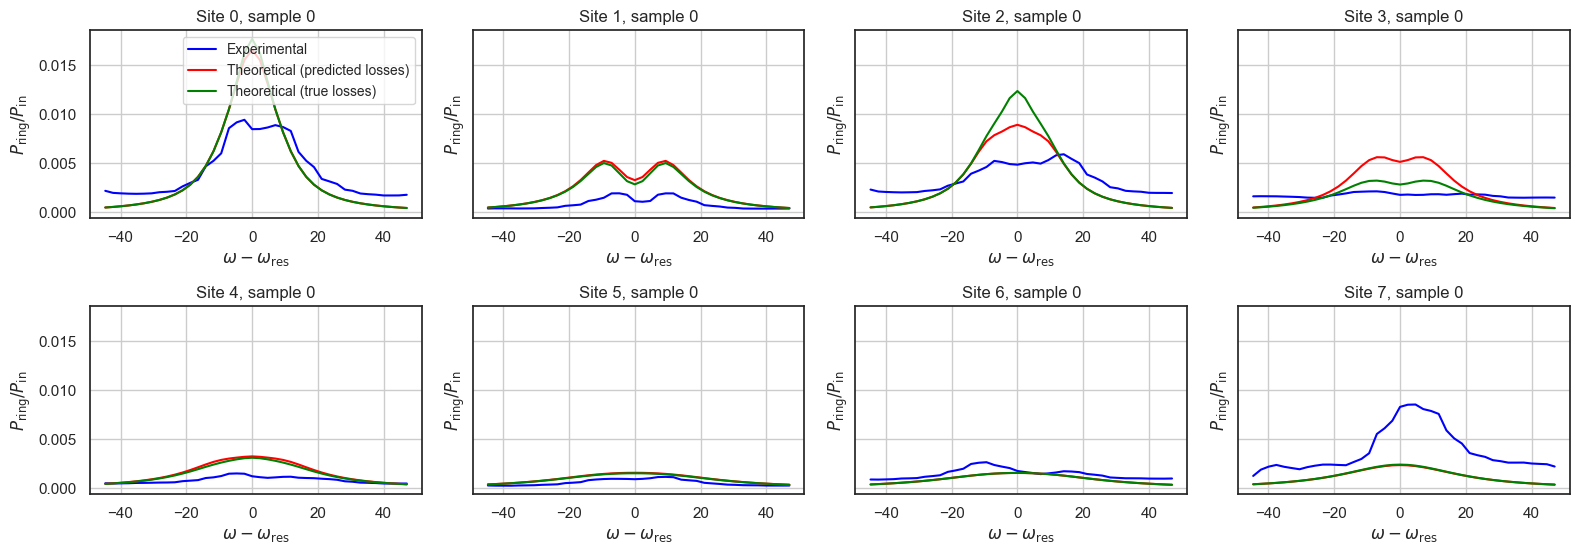

In [19]:
import numpy as np
import matplotlib.pyplot as plt

plotx = freqs


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k = 0
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(freqs, new_y_train[i+(8*k), :], label='Experimental', color='blue')
    ax.plot(freqs, new_X_train[i+(8*k), :], label='Theoretical (predicted losses)', color='red')
    ax.plot(freqs, X1_train_true[i+(8*k), :], label='Theoretical (true losses)', color='green')


    ax.set_title(f"Site {i}, sample {k}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()


In [20]:
# --- scale Stage 2 inputs (new_X, new_y) ---


from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.pipeline import make_pipeline

scalernx = StandardScaler()
new_X_train_scaled = scalernx.fit_transform(new_X_train)
new_X_test_scaled = scalernx.transform(new_X_test)

scalerny = StandardScaler()
new_y_train_scaled = scalerny.fit_transform(new_y_train)
new_y_test_scaled = scalerny.transform(new_y_test)


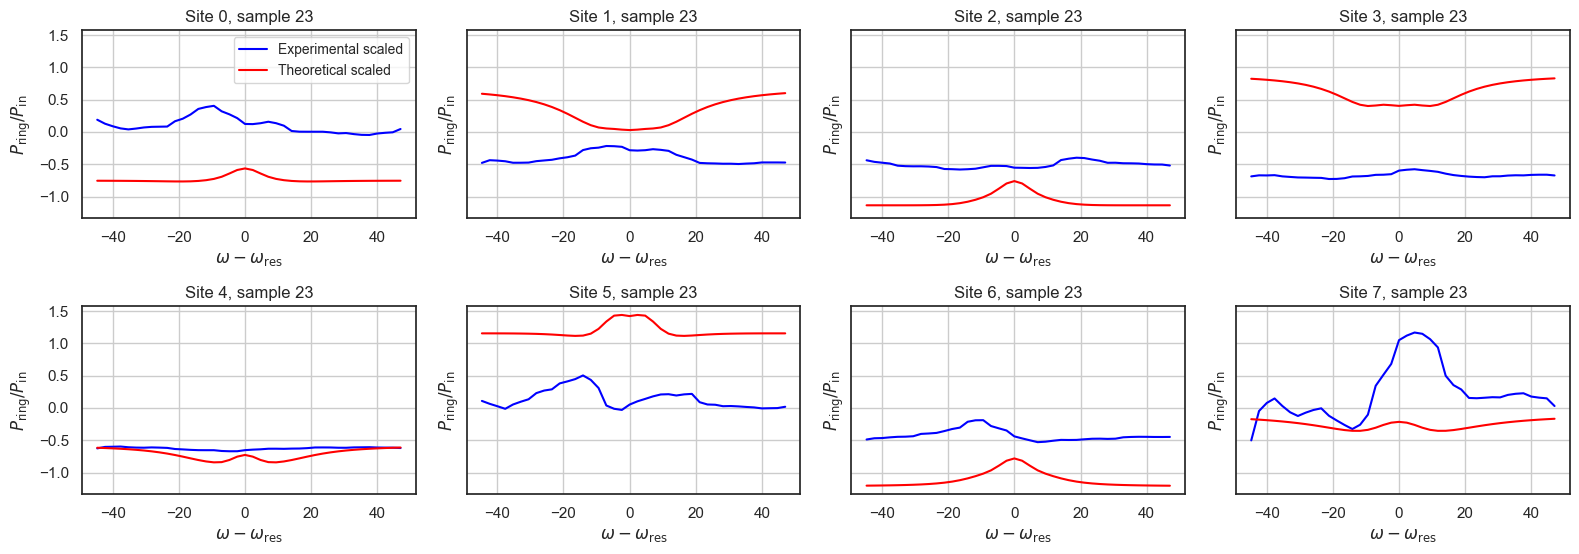

In [21]:
import numpy as np
import matplotlib.pyplot as plt

plotx = freqs


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k = 23
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(freqs, new_y_train_scaled[i+(8*k), :], label='Experimental scaled', color='blue')
    ax.plot(freqs, new_X_train_scaled[i+(8*k), :], label='Theoretical scaled', color='red')

    ax.set_title(f"Site {i}, sample {k}")

    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()


In [22]:
# --- Stage 2: learn mapping from theory spectra -> corrected/normalized experimental spectra ---
# Model lives in picml.models (keep architecture out of notebook).
# Add channel dim for Conv1D: (n_samples, n_freqs, 1).

import numpy as np


new_X_train_scaled_cnn = new_X_train_scaled[..., np.newaxis]
new_X_test_scaled_cnn = new_X_test_scaled[..., np.newaxis]

model_sc, history_sc, test_loss = train_case_A_model2(
    new_X_train_scaled_cnn,
    new_y_train_scaled,
    new_X_test_scaled_cnn,
    new_y_test_scaled)

print("Stage-2 test loss:", float(test_loss))

new_y_pred_train = model_sc.predict(new_X_train_scaled_cnn)
new_y_pred_test  = model_sc.predict(new_X_test_scaled_cnn)

print("pred train:", new_y_pred_train.shape, "true train:", new_y_train.shape)
print("pred test :", new_y_pred_test.shape,  "true test :", new_y_test.shape)


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.2572 - val_loss: 0.8795
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7741 - val_loss: 0.8809
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6445 - val_loss: 0.8931
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5357 - val_loss: 0.9040
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4350 - val_loss: 0.9132
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3318 - val_loss: 0.9024
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2711 - val_loss: 0.9144
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2474 - val_loss: 0.9213
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1879 - val_loss: 0.9171
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1252 - val_loss: 0.8871
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0619 - val_loss: 0.8051
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.

In [23]:
y_sample = model_sc.predict(new_X_train_scaled_cnn[:5])
print("Prediction shape:", y_sample.shape)   # should be (5, 40)
print("First prediction-second prediction:", y_sample[0]-y_sample[1])      # should vary, not constant


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Prediction shape: (5, 40)
First prediction-second prediction: [2.1847653 2.234915  2.2173095 2.2147715 2.2313712 2.210488  2.218217
 2.2229311 2.221167  2.239979  2.2531796 2.3013182 2.387157  2.4411201
 2.502561  2.697818  2.7421527 2.7826953 2.8070648 2.7813382 2.7659767
 2.632084  2.583572  2.482824  2.1586204 2.0171494 1.9764152 2.005758
 2.0381954 2.0837324 2.0887353 2.0773697 2.0559797 2.103253  2.1644714
 2.1786356 2.2008624 2.0983202 2.0246575 1.8925744]


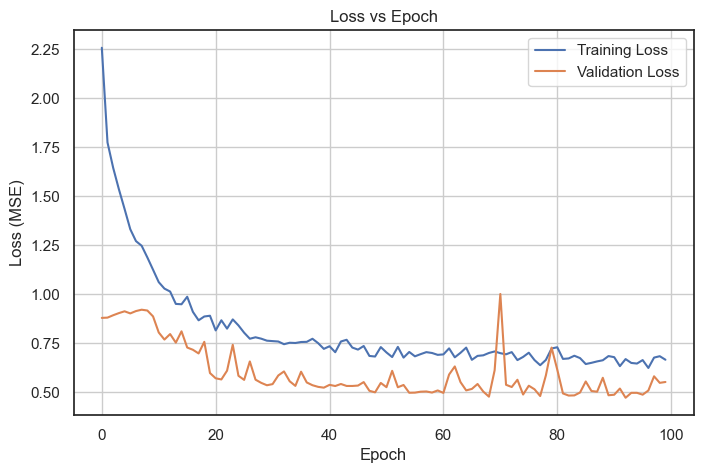

In [24]:
import matplotlib.pyplot as plt

# Extract training and validation loss from history
train_loss = history_sc['loss']
val_loss = history_sc['val_loss']

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
pred_y_train = scalerny.inverse_transform(new_y_pred_train)
pred_y_test = scalerny.inverse_transform(new_y_pred_test)

true_y_train = new_y_train
true_y_test = new_y_test


In [26]:
print(pred_y_test.shape)
print(true_y_test.shape)


(320, 40)
(320, 40)


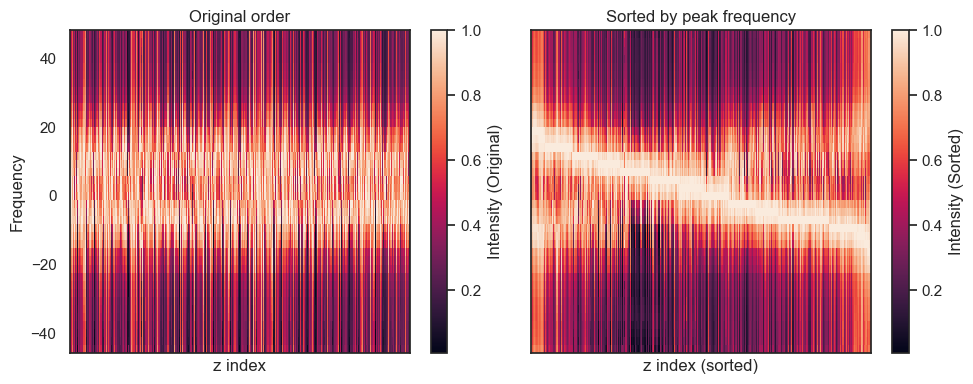

In [27]:
# --- Stage 2 evaluation and qualitative check ---for true power spectra
# Plot a few spectra overlays to see whether model 2 corrects systematic mismatch.
# Use shared color limits when comparing heatmaps across panels.

import numpy as np
import matplotlib.pyplot as plt


# --- Example data ---
z = np.array(true_y_test.flatten())
frequencies1 = np.array(freqs)
#S = np.array(true_y_test)
S = true_y_test / np.max(true_y_test, axis=1, keepdims=True)

# --- Sorting by where each row peaks ---
z_new, S_new, order = sort_by_peak_frequency(z, S)

# numeric z positions for plotting
z_numeric     = np.arange(S.shape[0])  # ✅ 320
z_numeric_new = np.arange(S_new.shape[0])

# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies1, S.T,
    shading='auto')#,vmin=0., vmax=0.8)
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks([])

fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies1, S_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks([])

fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()

In [28]:
#Sk = np.array(pred_y_test)
Sk = pred_y_test/ np.max(pred_y_test, axis=1, keepdims=True)
Sk_new = Sk[order, :]
print("S shape:", S.shape)
print("pred_y_test shape:", pred_y_test.shape)


S shape: (320, 40)
pred_y_test shape: (320, 40)


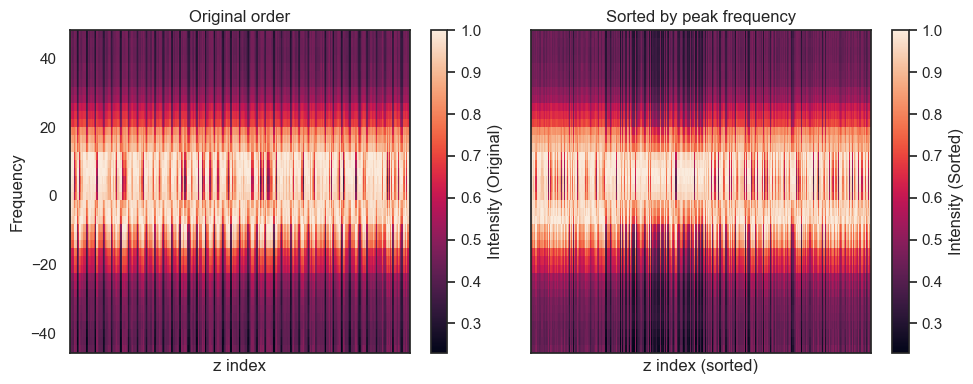

In [29]:
# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---for predicted output power spectra
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies1, Sk.T, shading='auto')
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks([])
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies1, Sk_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks([])
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()


In [84]:
#Save final output file
import numpy as np

# Suppose we already have:
# z_sorted : shape (N,) = (320,)
# frequencies : shape (F,) = (40,)
# S_sorted : shape (N, F)
# Sk_sorted : shape (N, F)

# --- Flatten to long table (z, freq, S, Sk) ---
N, F = S_new.shape

# Repeat z along each frequency
z_col0 = np.repeat(z_new + 0.5, F) 
z_col = np.repeat(z_numeric_new + 0.5, F)              # (N*F,)
# Tile frequencies for each z
f_col = np.tile(frequencies, N)             # (N*F,)

# Flatten spectra values
S_col  = S_new.flatten(order="C")        # (N*F,)
Sk_col = Sk_new.flatten(order="C")       # (N*F,)

# Stack into one 2D array
data = np.column_stack([z_col0,z_col, f_col, S_col, Sk_col])

# --- Save to file ---
header = "z_sorted\tz_sorted_numeric\tfrequency\tS_sorted\tSk_sorted"
np.savetxt(
    "predicted_result/spectra_sorted_case_A.dat",
    data,
    fmt="%.10g",
    delimiter="\t",
    header=header,
    comments=""
)

print("✅ Saved spectra_sorted_case_A.dat with shape", data.shape)


✅ Saved spectra_sorted.dat with shape (12800, 5)


"The End"